# Exercises - Machine Learning for logistic regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Sonar dataset

In this exercise, you will solve a binary classification problem solved using logistic regression. The dataset consists of 60 features corresponding to sonar measurements, with a binary label that indicates whether the sample is a rock (0) or a mine (1).

In [3]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [4]:
data = np.loadtxt("data/logistic_regression/sonar.csv", delimiter = ",")
X = data[:, :-1]
y = data[:, -1]

In [5]:
# shuffling of the dataset
np.random.shuffle(data)
num_features = X.shape[1]
X_shuffled = data[:,:num_features]
y_shuffled = data[:,num_features]

1. Standardize the shuffled dataset according to the mean and the standard deviation over the samples. Split the dataset into training (80%) and test (20%) sets.

In [28]:
# standardization of the dataset
mean_X = np.mean(X_shuffled, axis=0)
std_X = np.std(X_shuffled, axis=0)
X_norm = (X_shuffled-mean_X)/std_X

In [29]:
# train-test split
X_train=X_norm[:170]
X_test=X_norm[170:]

# adding column of ones
X_train = np.hstack((np.ones((X_train.shape[0],1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))

y_train=y_shuffled[:170].reshape(-1,1)
y_test=y_shuffled[170:].reshape(-1,1)

2. Use the _LogisticRegression_ class from the example (toy dataset) to build and train a model. Adjust the number of epochs and learning rate. Plot the cost vs epochs.

In [30]:
class LogisticRegression:
    def __init__ (self, num_features):
        self.weights = np.random.random_sample((num_features + 1,1))
        
    def fit(self, X, y, epochs, learning_rate):
        self.costs=[]

        N = X.shape[0]
                
        for i in range(epochs):
            # compute sigma(Xw)
            output = self.activation(X)
            errors = output-y
            # update weights
            self.weights -= learning_rate/N*X.T @ errors
            # compute the cost
            cost = (-y.T @ np.log(output)-(1 - y.T) @ np.log(1 - output))/N
            self.costs.append(cost.item())
        
    def activation(self, X):
        return sigmoid(X @ self.weights)   
        
    def predict(self, X):        
        return np.where(self.activation(X)>=0.5,1,0)

In [31]:
lr=LogisticRegression(num_features=num_features)
lr.fit(X=X_train, y=y_train, epochs=1000, learning_rate=0.1)

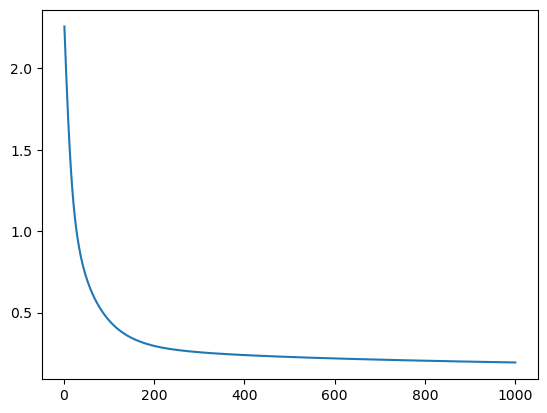

In [32]:
# Ploting cost value vs number of iterations
plt.plot(np.arange(1,len(lr.costs)+1,1),lr.costs)
plt.show()

3. Evaluate the misclassifications (number of wrong classifications) over the training and the test sets. Compute the accuracy (number of correct classifications/number of samples) over the training and the test sets.

In [33]:
train_prediction = lr.predict(X_train)
test_prediction=lr.predict(X_test)
missclassification_train = (y_train!=train_prediction).sum()
missclassification_test = (y_test!=test_prediction).sum()
print('Misclassifications Training:', missclassification_train)
print('Misclassifications Test:',missclassification_test)
print('Accuracy Training:', 1 - missclassification_train/X_train.shape[0])
print('Accuracy Test:', 1 - missclassification_test/X_test.shape[0])

Misclassifications Training: 10
Misclassifications Test: 7
Accuracy Training: 0.9411764705882353
Accuracy Test: 0.8157894736842105


## XOR dataset

In this exercise, you will implement regularized logistic regression to learn the XOR function from a noisy dataset.

In [1537]:
import numpy as np
import matplotlib.pyplot as plt

In [1580]:
# Load and shuffle the dataset
data = np.loadtxt("data/logistic_regression/xor.txt", delimiter = ",")
np.random.shuffle(data)
X = data[:, :-1]
y = data[:, -1]
num_samples = X.shape[0]

In [1581]:
# Auxiliary functions
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def mapFeatureNormalized(X1, X2):
    degree = 8
    out = np.ones((len(X1),1))
    for i in range(1,degree+1):
        for j in range(0,i+1):
            prod = (X1**(i-j))*(X2**j)
            mean_prod = np.mean(prod)
            std_prod = np.std(prod)
            norm_prod = (prod-mean_prod)/std_prod
            out = np.append(out, norm_prod.reshape(-1,1), axis=1)
    return out

def plotDecisionBoundary(model):
    x1s = np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
    x2s = np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)
    xs, ys = np.meshgrid(x1s, x2s, indexing='ij')
    Xs = mapFeatureNormalized(xs.ravel(), ys.ravel())
    zs = Xs @ model.weights
    plt.contour(xs, ys, zs.reshape((len(x1s),len(x2s))), [0.])
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()

In [1582]:
# Extend the features of the dataset up to sixth powers (with standardization)
X_ = mapFeatureNormalized(X[:,0], X[:,1])
num_features = X_.shape[1]

# Split the dataset (0.6-0.2-0.2)
n_train = int(0.6*num_samples)
n_val = int(0.2*num_samples)

X_train = X_[:n_train,:]
y_train = y[:n_train]
X_val = X_[n_train:n_train+n_val,:]
y_val = y[n_train:n_train+n_val]
X_test = X_[n_train+n_val:,:]
y_test = y[n_train+n_val:]

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)

1. Plot the dataset (scatter plot).

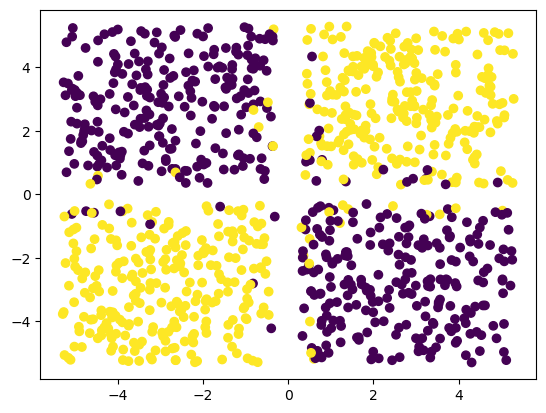

In [1583]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

2. Implement the _LogisticRegression_ class with Tikhonov regularization. Add a method called `accuracy` that computes the prediction accuracy on a given dataset.

In [1584]:
class LogisticRegression:
    def __init__ (self, num_features):
        self.weights = np.random.random_sample((num_features,1))
        
    def fit(self, X, y, epochs, learning_rate, reg_param):
        # NOTE: here the first column of X must contain ones
        self.costs=[]

        N = X.shape[0]
        
        for i in range(epochs):
            # compute \sigma(Xw)
            output = self.activation(X)
            errors = output-y
            # update weights (with L2 regularization)
            self.weights -= learning_rate/N*((X.T @ errors) + 2*reg_param*self.weights)
            # compute the cost
            cost = (-y.T @ np.log(output)-(1 - y.T) @ np.log(1 - output+1e-10) + reg_param*np.linalg.norm(self.weights)**2)/N
            self.costs.append(cost.item())
    
    def activation(self, X):
        return sigmoid(X @ self.weights)   
        
    def predict(self, X):        
        return np.where(self.activation(X)>=0.5,1,0)

    def accuracy(self, X, y):
        pred = self.predict(X)
        return (pred==y).sum()/X.shape[0]

3. Train a Logistic Regression model on the training set for 10000 epochs with `reg_param = 0.` and `learning_rate = 1.` and evaluate its accuracy on the training, validation and test sets.

In [1585]:
model = LogisticRegression(num_features=num_features)
model.fit(X_train, y_train, 10000, 1., 0.)
print("Accuracy on the training set = ", model.accuracy(X_train, y_train))
print("Accuracy on validation set = ", model.accuracy(X_val, y_val))
print("Accuracy on test set = ", model.accuracy(X_test, y_test))

Accuracy on the training set =  0.9583333333333334
Accuracy on validation set =  0.92
Accuracy on test set =  0.95


4. Plot the cost (training) vs epochs and the decision boundary (use the auxiliary function defined above).

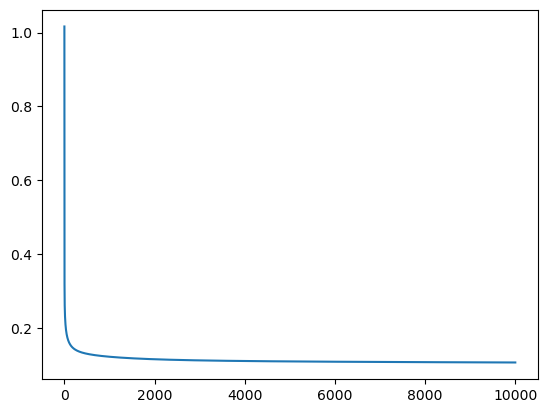

In [1586]:
plt.plot(np.arange(1,len(model.costs)+1,1),model.costs)
plt.show()

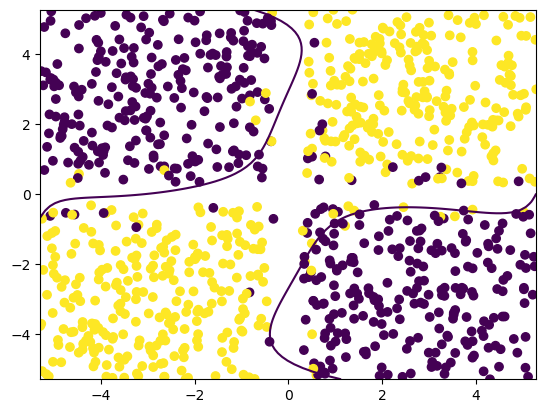

In [1587]:
plotDecisionBoundary(model)

5. Perform a grid search to find the "best" regularization parameter in the interval (0.,1.), while keeping fixed the learning rate and the number of epochs. Re-train the model using the best value and the training+validation set.

In [1588]:
reg_params = [0., 1e-2, 1e-1, 5e-1, 1.]
val_acc = []
for reg_param in reg_params:
    m = LogisticRegression(num_features=num_features)
    m.fit(X_train, y_train, 10000, 1., reg_param)
    val_acc.append(m.accuracy(X_val, y_val))

In [1589]:
# Best value of the regularization parameter
best_reg = reg_params[np.argmax(val_acc)]
print(best_reg)

1.0


In [1590]:
# Re-train the model using training+validation and using the best value for the regularization parameter
X_train = np.vstack([X_train, X_val])
y_train = np.vstack([y_train, y_val])
model.fit(X_train, y_train, 10000, 1., best_reg)
print("Accuracy on the training set = ", model.accuracy(X_train, y_train))
print("Accuracy on the validation set = ", model.accuracy(X_val, y_val))

Accuracy on the training set =  0.9475
Accuracy on the validation set =  0.93


6. Plot the decision boundary of the fitted model and evaluate the accuracy on the test set.

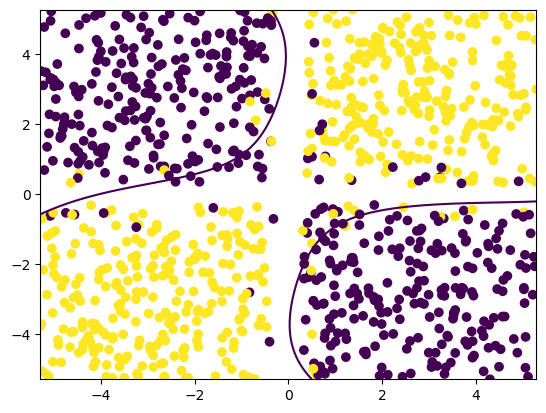

In [1591]:
plotDecisionBoundary(model)

In [1592]:
print("Accuracy on test set = ", model.accuracy(X_test, y_test))

Accuracy on test set =  0.955
